# 1. Load Train Image

In [34]:
import numpy as np
import tensorflow as tf

In [2]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #GPU_ID from earlier

config = tf.compat.v1.ConfigProto()
sess = tf.compat.v1.Session(config=config)

In [45]:
X_train = np.load('./test_set/X_train.npy')
X_test = np.load('./test_set/X_test.npy')
X_valid = np.load('./test_set/X_valid.npy')

In [46]:
Y_train = np.load('./test_set/Y_train.npy')
Y_test = np.load('./test_set/Y_test.npy')
Y_valid = np.load('./test_set/Y_valid.npy')

# 2. Train Facenet

In [35]:
weights_filename = './facenet/facenet_keras_weights.h5'
model_filename = './facenet/facenet_keras.h5'

In [36]:
from keras.models import *
facenet = load_model(model_filename)

In [37]:
facenet.load_weights(weights_filename)

In [38]:
facenet._layers[0]._batch_input_shape = (None,200,200,3)
new_facenet = model_from_json(facenet.to_json())

In [39]:
for layer in new_facenet.layers[1:]:
    try:
        layer.set_weights(facenet.get_layer(name=layer.name).get_weights())
        print('loaded weights {}'.format(layer.name))
    except:
        print('Could not transfer weights {}'.format(layer.name))

loaded weights Conv2d_1a_3x3
loaded weights Conv2d_1a_3x3_BatchNorm
loaded weights Conv2d_1a_3x3_Activation
loaded weights Conv2d_2a_3x3
loaded weights Conv2d_2a_3x3_BatchNorm
loaded weights Conv2d_2a_3x3_Activation
loaded weights Conv2d_2b_3x3
loaded weights Conv2d_2b_3x3_BatchNorm
loaded weights Conv2d_2b_3x3_Activation
loaded weights MaxPool_3a_3x3
loaded weights Conv2d_3b_1x1
loaded weights Conv2d_3b_1x1_BatchNorm
loaded weights Conv2d_3b_1x1_Activation
loaded weights Conv2d_4a_3x3
loaded weights Conv2d_4a_3x3_BatchNorm
loaded weights Conv2d_4a_3x3_Activation
loaded weights Conv2d_4b_3x3
loaded weights Conv2d_4b_3x3_BatchNorm
loaded weights Conv2d_4b_3x3_Activation
loaded weights Block35_1_Branch_2_Conv2d_0a_1x1
loaded weights Block35_1_Branch_2_Conv2d_0a_1x1_BatchNorm
loaded weights Block35_1_Branch_2_Conv2d_0a_1x1_Activation
loaded weights Block35_1_Branch_1_Conv2d_0a_1x1
loaded weights Block35_1_Branch_2_Conv2d_0b_3x3
loaded weights Block35_1_Branch_1_Conv2d_0a_1x1_BatchNorm
loa

In [40]:
for layer in new_facenet.layers:
    layer.trainable = False

In [41]:
new_facenet.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 99, 99, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 99, 99, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 99, 99, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

In [42]:
from keras.layers import Flatten, Dense, Input
model = Sequential([
    new_facenet, 
    Dense(1, 'sigmoid')
])

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v1 (Functio (None, 128)               22808144  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 22,808,273
Trainable params: 129
Non-trainable params: 22,808,144
_________________________________________________________________


In [48]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy',patience=5)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(
    X_train,Y_train,
    epochs = 10,
    batch_size = 64,
    validation_data = (X_valid,Y_valid),
    shuffle=True,
    callbacks=[early_stopping],
)

Epoch 1/10
70/70 [==============================] - 32s 452ms/step - loss: 0.5140 - accuracy: 0.7625 - val_loss: 0.4135 - val_accuracy: 0.8438
Epoch 2/10
70/70 [==============================] - 30s 433ms/step - loss: 0.3715 - accuracy: 0.8587 - val_loss: 0.3528 - val_accuracy: 0.8607
Epoch 3/10
70/70 [==============================] - 30s 432ms/step - loss: 0.3283 - accuracy: 0.8732 - val_loss: 0.3226 - val_accuracy: 0.8759
Epoch 4/10
70/70 [==============================] - 30s 433ms/step - loss: 0.3018 - accuracy: 0.8857 - val_loss: 0.3030 - val_accuracy: 0.8830
Epoch 5/10
70/70 [==============================] - 30s 434ms/step - loss: 0.2927 - accuracy: 0.8879 - val_loss: 0.2895 - val_accuracy: 0.8920
Epoch 6/10
70/70 [==============================] - 30s 433ms/step - loss: 0.2789 - accuracy: 0.8922 - val_loss: 0.2795 - val_accuracy: 0.9000
Epoch 7/10
70/70 [==============================] - 30s 433ms/step - loss: 0.2704 - accuracy: 0.8964 - val_loss: 0.2716 - val_accuracy: 0.9036

In [49]:
loss, acc = model.evaluate(X_test,Y_test)
print('\nLoss: {}, Acc: {}'.format(loss,acc))

44/44 [==============================] - 7s 167ms/step - loss: 0.2281 - accuracy: 0.9236

Loss: 0.2280530035495758, Acc: 0.9235714077949524


In [50]:
model.save('./test_set/pretrained_facenet.h5')

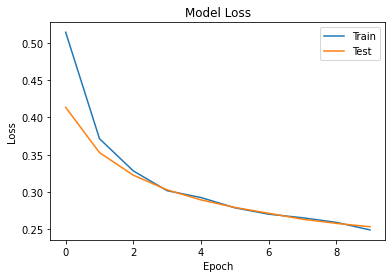

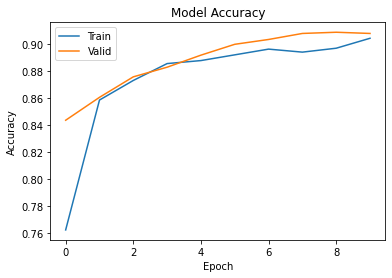

In [51]:
import matplotlib.pyplot as plt
def plt_show_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc=0)

def plt_show_acc(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Valid'],loc=0)
plt_show_loss(history)
plt.show()
plt_show_acc(history)
plt.show()

In [52]:
from sklearn.metrics import classification_report
Y_pred = model.predict(X_test)
Y_pred = np.where(Y_pred>0.5, 1 ,0)
print(classification_report(Y_test,Y_pred, digits=4))

              precision    recall  f1-score   support

         0.0     0.9559    0.8848    0.9190       686
         1.0     0.8967    0.9608    0.9277       714

    accuracy                         0.9236      1400
   macro avg     0.9263    0.9228    0.9233      1400
weighted avg     0.9257    0.9236    0.9234      1400



# 4-1. Test Model -> unchanged test set

In [1]:
from keras.models import load_model
model = load_model('./test_set/pretrained_facenet.h5')

In [73]:
ctz_original = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/frontal_ctz_original_4.npy')
mgs_original = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/frontal_mgs_original_4.npy')

In [77]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
original_img = np.append(ctz_original, mgs_original, axis=0)
y = np.append(np.zeros(shape=ctz_original.shape[0]), np.ones(shape=mgs_original.shape[0]), axis=0)

#skin change 하지 않은 예측값 
original_y_pred = model.predict(original_img)
original_y_pred = np.where(original_y_pred>0.5, 1, 0)
print(confusion_matrix(y,original_y_pred))

[[618  82]
 [ 39 661]]


In [78]:
print(classification_report(y,original_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.9406    0.8829    0.9108       700
         1.0     0.8896    0.9443    0.9161       700

    accuracy                         0.9136      1400
   macro avg     0.9151    0.9136    0.9135      1400
weighted avg     0.9151    0.9136    0.9135      1400



# 4-2. Test Model -> Skin changed test set

In [59]:
ctz_skin_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_skin_changed_4.npy')
mgs_skin_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_skin_changed_4.npy')

In [80]:
changed_img = np.append(ctz_skin_changed, mgs_skin_changed, axis=0)
y = np.append(np.zeros(shape=ctz_skin_changed.shape[0]), np.ones(shape=mgs_skin_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[576 124]
 [ 84 616]]


In [81]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8727    0.8229    0.8471       700
         1.0     0.8324    0.8800    0.8556       700

    accuracy                         0.8514      1400
   macro avg     0.8526    0.8514    0.8513      1400
weighted avg     0.8526    0.8514    0.8513      1400



# 4-3. Test Model -> Nose changed test set

In [62]:
ctz_nose_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_nose_changed_3.npy')
mgs_nose_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_nose_changed_3.npy')

In [83]:
ctz_nose_changed_idx = random.sample([i for i in range(ctz_nose_changed.shape[0])], 700)
mgs_nose_changed_idx = random.sample([i for i in range(mgs_nose_changed.shape[0])], 700)

ctz_nose_changed = ctz_nose_changed[ctz_nose_changed_idx]
mgs_nose_changed = mgs_nose_changed[mgs_nose_changed_idx]

In [84]:
changed_img = np.append(ctz_nose_changed, mgs_nose_changed, axis=0)
y = np.append(np.zeros(shape=ctz_nose_changed.shape[0]), np.ones(shape=mgs_nose_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[614  86]
 [ 81 619]]


In [85]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8835    0.8771    0.8803       700
         1.0     0.8780    0.8843    0.8811       700

    accuracy                         0.8807      1400
   macro avg     0.8807    0.8807    0.8807      1400
weighted avg     0.8807    0.8807    0.8807      1400



# 4-4. Test Model -> Lip changed test set

In [65]:
ctz_lip_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_lip_changed_4.npy')
mgs_lip_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_lip_changed_4.npy')

In [87]:
changed_img = np.append(ctz_lip_changed, mgs_lip_changed, axis=0)
y = np.append(np.zeros(shape=ctz_lip_changed.shape[0]), np.ones(shape=mgs_lip_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[628  72]
 [ 46 654]]


In [88]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.9318    0.8971    0.9141       700
         1.0     0.9008    0.9343    0.9173       700

    accuracy                         0.9157      1400
   macro avg     0.9163    0.9157    0.9157      1400
weighted avg     0.9163    0.9157    0.9157      1400



# 4-5. Test Model -> Skin, Nose, Lip test set

In [68]:
ctz_total_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/ctz_blacked/ctz_total_changed_4.npy')
mgs_total_changed = np.load('/home/dxlab/jupyter/soyoung/racist_model/Detect-Facial-Features/features_changed/mgs_whited/mgs_total_changed_4.npy')

In [96]:
changed_img = np.append(ctz_total_changed, mgs_total_changed, axis=0)
y = np.append(np.zeros(shape=ctz_total_changed.shape[0]), np.ones(shape=mgs_total_changed.shape[0]), axis=0)

changed_y_pred = model.predict(changed_img)
changed_y_pred = np.where(changed_y_pred>0.5, 1, 0)

print(confusion_matrix(y,changed_y_pred))

[[611  89]
 [121 579]]


In [97]:
print(classification_report(y,changed_y_pred,digits=4))

              precision    recall  f1-score   support

         0.0     0.8347    0.8729    0.8534       700
         1.0     0.8668    0.8271    0.8465       700

    accuracy                         0.8500      1400
   macro avg     0.8507    0.8500    0.8499      1400
weighted avg     0.8507    0.8500    0.8499      1400

